In [1]:
import os
import json
import requests
from dotenv import load_dotenv
from requests.exceptions import Timeout, ConnectionError
from newsapi import NewsApiClient

In [2]:
# connects local environment to langsmith projects, re run the code
os.environ ["LANGSMITH_TRACING"]="true"
os.environ ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ ["LANGSMITH_API_KEY"]="<key>"
os.environ ["LANGSMITH_PROJECT"]="Crypto Analysis Agent"

In [3]:
load_dotenv()

FREECRYPTO_TOKEN = os.getenv("FREECRYPTO_TOKEN")

headers = {
    "Authorization": f"Bearer {FREECRYPTO_TOKEN}"
}

In [4]:
url = "https://api.freecryptoapi.com/v1/getCryptoList"

In [5]:
response = requests.get(url, headers=headers)

data = response.json()

print(json.dumps(data, indent=2))

{
  "status": true,
  "resultset_size": 4446,
  "result": [
    {
      "id": "1",
      "symbol": "BTC",
      "name": "Bitcoin ",
      "source": "binance",
      "ohlc_available_from": "2023-01-25",
      "history_available_from": "2016-12-17"
    },
    {
      "id": "2",
      "symbol": "ETH",
      "name": "Ethereum ",
      "source": "binance",
      "ohlc_available_from": "2023-01-25",
      "history_available_from": "2016-12-18"
    },
    {
      "id": "3",
      "symbol": "LTC",
      "name": "Litecoin ",
      "source": "binance",
      "ohlc_available_from": "2023-01-25",
      "history_available_from": "2016-12-18"
    },
    {
      "id": "4",
      "symbol": "BNB",
      "name": "Binance Coin ",
      "source": "binance",
      "ohlc_available_from": "2023-01-25",
      "history_available_from": "2016-12-17"
    },
    {
      "id": "5",
      "symbol": "NEO",
      "name": "NEO ",
      "source": "binance",
      "ohlc_available_from": "2023-01-25",
      "history_avai

In [6]:
url = "https://api.freecryptoapi.com/v1/getData"

In [7]:
params = {
    "symbol": "BTC"
}

In [8]:
response = requests.get(url, headers=headers, params=params)

data = response.json()

print(json.dumps(data, indent=2))

{
  "status": "success",
  "symbols": [
    {
      "symbol": "BTC",
      "last": "87416.6",
      "last_btc": "1",
      "lowest": "85398.84",
      "highest": "88131.5",
      "date": "2025-12-16 22:23:08",
      "daily_change_percentage": "1.8706139277532",
      "source_exchange": "binance"
    }
  ]
}


In [9]:
from newsapi import NewsApiClient

In [10]:
NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")

newsapi = NewsApiClient(api_key=NEWSAPI_KEY)

In [11]:
articles = newsapi.get_everything(
    q="bitcoin",
    language="en",
    sort_by="relevancy",
    page=1
)

print(json.dumps(articles, indent=2))

{
  "status": "ok",
  "totalResults": 10409,
  "articles": [
    {
      "source": {
        "id": "wired",
        "name": "Wired"
      },
      "author": "Joel Khalili",
      "title": "Inside a Wild Bitcoin Heist: Five-Star Hotels, Cash-Stuffed Envelopes, and Vanishing Funds",
      "description": "Sophisticated crypto scams are on the rise. But few of them go to the lengths one bitcoin mining executive experienced earlier this year.",
      "url": "https://www.wired.com/story/bitcoin-scam-mining-as-service/",
      "urlToImage": "https://media.wired.com/photos/6913b909f757bec53ccf7811/191:100/w_1280,c_limit/Bitcoin-Heist-Business-1304706668.jpg",
      "publishedAt": "2025-11-17T10:00:00Z",
      "content": "As Kent Halliburton stood in a bathroom at the Rosewood Hotel in central Amsterdam, thousands of miles from home, running his fingers through an envelope filled with 10,000 in crisp banknotes, he sta\u2026 [+2362 chars]"
    },
    {
      "source": {
        "id": null,
     

In [12]:
from typing import Optional
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

In [13]:
load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
FREECRYPTO_TOKEN = os.getenv("FREECRYPTO_TOKEN")
NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")

if not OPENAI_API_KEY or not FREECRYPTO_TOKEN or not NEWSAPI_KEY:
    raise RuntimeError("Missing one or more required environment variables.")

In [14]:
llm = ChatOpenAI(model="gpt-4o")

In [15]:
@tool
def crypto_list_tool(limit: int = 25) -> str:
    """
    Fetches a list of available cryptocurrencies (symbol + name) from FreeCryptoAPI.

    Args:
        limit (int): Max number of coins to return (to keep responses compact).

    Returns:
        str: JSON string with a condensed list:
             [{"symbol": "...", "name": "..."}, ...]
    """
    url = "https://api.freecryptoapi.com/v1/getCryptoList"
    headers = {"Authorization": f"Bearer {FREECRYPTO_TOKEN}"}

    resp = requests.get(url, headers=headers, timeout=30)

    try:
        data = resp.json()
    except Exception:
        return json.dumps({"status": False, "error": "Invalid JSON from API"})

    if isinstance(data, list):
        slim = []
        for item in data[: max(1, limit)]:
            sym = item.get("symbol") or item.get("Symbol") or item.get("ticker")
            nm = item.get("name") or item.get("Name")
            if sym or nm:
                slim.append({"symbol": sym, "name": nm})

        return json.dumps({"status": True, "coins": slim}, indent=2)

    return json.dumps(data, indent=2)


In [16]:
@tool
def crypto_data_tool(symbol: str) -> str:
    """
    Fetches detailed data (price, supply, etc.) for a single cryptocurrency
    from FreeCryptoAPI.

    Args:
        symbol (str): Cryptocurrency symbol (e.g., BTC, ETH).

    Returns:
        str: JSON-formatted string with coin data or an error message.
    """
    url = "https://api.freecryptoapi.com/v1/getData"
    headers = {"Authorization": f"Bearer {FREECRYPTO_TOKEN}"}
    params = {"symbol": symbol.upper().strip()}

    resp = requests.get(url, headers=headers, params=params, timeout=30)

    try:
        data = resp.json()
    except Exception:
        return json.dumps({"status": False, "error": "Invalid JSON from API"})

    return json.dumps(data, indent=2)


In [17]:
@tool
def crypto_news_tool(query: str, max_items: int = 5) -> str:
    """
    Fetches recent news articles related to a cryptocurrency or topic
    using the NewsAPI.

    Args:
        query (str): Search term (e.g., "bitcoin", "ethereum").
        max_items (int): Maximum number of articles to return.

    Returns:
        str: JSON-formatted string containing a condensed list of articles.
    """
    newsapi = NewsApiClient(api_key=NEWSAPI_KEY)

    try:
        res = newsapi.get_everything(
            q=query,
            language="en",
            sort_by="publishedAt",
            page=1
        )
    except Exception:
        return json.dumps({"status": False, "error": "NewsAPI request failed"})

    articles = res.get("articles", [])

    slim = []
    for art in articles[: max(1, max_items)]:
        slim.append({
            "title": art.get("title"),
            "source": (art.get("source") or {}).get("name"),
            "url": art.get("url"),
            "publishedAt": art.get("publishedAt")
        })

    result = {
        "status": True,
        "totalResults": res.get("totalResults"),
        "returned": len(slim),
        "articles": slim
    }

    return json.dumps(result, indent=2)


In [18]:
tools = [
    crypto_list_tool,
    crypto_data_tool,
    crypto_news_tool,
]

In [19]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools=tools)

In [20]:
llm_with_tools = llm.bind_tools(tools)

In [21]:
system_prompt = """
You are a Crypto Market Analyst.

Your job is to help users understand cryptocurrencies using real, factual data.
You MUST rely on the available tools to fetch prices, coin data, and news.
Do NOT fabricate prices, market caps, or supply numbers.

When responding:
- Use tools for factual information
- Clearly summarize findings
- Present structured outputs with:
  Summary
  Data
  What it means
  Next steps

If a tool returns an error or missing data, clearly explain the issue.
When citing prices, prefer fields like priceUsd if available.
"""

In [22]:
from langgraph.graph import StateGraph, END
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import tools_condition
from langchain_core.messages import SystemMessage

In [23]:
sys_msg = SystemMessage(content=system_prompt)

In [24]:
def assistant(state: MessagesState):
    return {
        "messages": [
            llm_with_tools.invoke([sys_msg] + state["messages"])
        ]
    }

In [25]:
graph = StateGraph(MessagesState)

In [26]:
graph.add_node("assistant", assistant)
graph.add_node("tools", tool_node)

In [27]:
graph.set_entry_point("assistant")

In [28]:
graph.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "tools": "tools",
        END: END,
    }
)

In [29]:
graph.add_edge("tools", "assistant")

In [30]:
react_graph = graph.compile()

In [31]:
from langgraph.checkpoint.memory import MemorySaver

checkpointer = MemorySaver()
react_graph_with_memory = graph.compile(checkpointer=checkpointer)

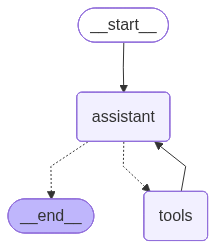

In [32]:
from IPython.display import Image, display

display(
    Image(
        react_graph.get_graph(xray=True).draw_mermaid_png()
    )
)

In [33]:
from langchain_core.messages import HumanMessage

In [34]:
messages = [
    HumanMessage(
        content="""
Compare BTC and ETH: current data + 3 latest headlines each.
Which looks stronger short-term? Keep it concise.
"""
    )
]

In [35]:
out = react_graph.invoke({"messages": messages})

In [36]:
for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

================================ Human Message =================================


Compare BTC and ETH: current data + 3 latest headlines each.
Which looks stronger short-term? Keep it concise.

================================== Ai Message ==================================
Tool Calls:
  crypto_data_tool (call_SoAhapGEXxsE1WFcnAzrgjvn)
 Call ID: call_SoAhapGEXxsE1WFcnAzrgjvn
  Args:
    symbol: BTC
  crypto_data_tool (call_KWhXSs0i7twSje791pODr5xA)
 Call ID: call_KWhXSs0i7twSje791pODr5xA
  Args:
    symbol: ETH
  crypto_news_tool (call_Avi8nHNnt7caQElRvY8ZZBaS)
 Call ID: call_Avi8nHNnt7caQElRvY8ZZBaS
  Args:
    query: bitcoin
    max_items: 3
  crypto_news_tool (call_poyMhRzBIuk70p6ydHji2B0h)
 Call ID: call_poyMhRzBIuk70p6ydHji2B0h
  Args:
    query: ethereum
    max_items: 3
================================= Tool Message =================================
Name: crypto_data_tool

{
  "status": "success",
  "symbols": [
    {
      "symbol": "BTC",
      "last": "87405.09",
      "last

In [ ]:
messages = [
    HumanMessage(
        content="Show me any 5 cryptocurrencies and their symbols"
    )
]

out = react_graph.invoke({"messages": messages})

for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

In [ ]:
messages = [
    HumanMessage(
        content="Give me current data for BTC and explain the key metrics in bullets"
    )
]

out = react_graph.invoke({"messages": messages})

for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

In [ ]:
messages = [
    HumanMessage(
        content="Give me five recent articles on Ethereum, including titles and links"
    )
]

out = react_graph.invoke({"messages": messages})

for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

In [ ]:
messages = [
    HumanMessage(
        content="""
Compare BTC and ETH: current data + 3 latest headlines each.
Which looks stronger short-term? Keep it concise.
"""
    )
]

out = react_graph.invoke({"messages": messages})

for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

In [ ]:
memory = MemorySaver()
react_graph_memory = graph.compile(checkpointer=memory)

In [ ]:
config = {
    "configurable": {
        "thread_id": "crypto-thread-1"
    }
}

In [ ]:
messages = [
    HumanMessage(
        content="Give me current data for BTC and summarize the key metrics."
    )
]

In [ ]:
out = react_graph_memory.invoke(
    {"messages": messages},
    config=config
)

In [ ]:
for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

In [ ]:
messages = [
    HumanMessage(
        content="Now compare it with ETH and tell me which looks stronger short-term."
    )
]

In [ ]:
out = react_graph_memory.invoke(
    {"messages": messages},
    config=config
)

In [ ]:
for m in out["messages"]:
    try:
        m.pretty_print()
    except Exception:
        print(m)

In [ ]:
print("💬 Crypto Agent Interactive Chat")
print("Type your question and press Enter.")
print("Type 'exit' or 'quit' to end the session.\n")

while True:
    try:
        user_input = input("You: ").strip()

        if not user_input:
            continue

        if user_input.lower() in {"exit", "quit"}:
            print("👋 Bye!")
            break

        messages = [HumanMessage(content=user_input)]

        result = react_graph_memory.invoke(
            {"messages": messages},
            config
        )

        last_ai = next(
            (m for m in reversed(result["messages"]) if m.type == "ai"),
            None
        )

        print(
            f"🤖 Agent: {last_ai.content}\n"
            if last_ai
            else "🤖 Agent: [No reply]\n"
        )

    except KeyboardInterrupt:
        print("\n👋 Bye!")
        break
    except EOFError:
        print("\n👋 Bye!")
        break
    except Exception as e:
        print(f"⚠️ Error: {e}")
